In [1]:
import skimage
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.ndimage import binary_dilation

In [2]:
root_growth_directions = ((0, -1), (1, -1), (1, 0), (1, 1), (0, 1)) # W, SW, S, SE, E

pr_growth_weights = [1, 4, 8, 4, 1]
llr_growth_weights = [4, 8, 4, 0.1, 0.1]
rlr_growth_weights = [0.1, 0.1, 4, 8, 4]

In [3]:
def root_grower(img, directions, start):
    root_coordinates = [start]
    patch_size = img.shape[0]
    for growth_direction in directions:
        end = (start[0] + growth_direction[0], start[1] + growth_direction[1])
        if 0 <= end[0] < patch_size and 0 <= end[1] < patch_size:
            img[end[0], end[1]] = 1
            root_coordinates.append(end)
            start = end
        else:
            break
    return img, root_coordinates

In [4]:
def root_mask_simulator(patch_size):
    pr_len = np.random.randint(100, 500)
    lr_len = pr_len // 2
    step_size = 3

    img = np.zeros((patch_size, patch_size), dtype=np.uint8)

    pr_start = [np.random.randint(0+5, patch_size//2), np.random.randint(0+10, patch_size-10)]
    img[pr_start[0], pr_start[1]] = 1

    pr_growth_directions = random.choices(root_growth_directions, weights=pr_growth_weights, k=pr_len//step_size)
    pr_growth_directions = [element for element in pr_growth_directions for _ in range(step_size)]

    img, pr_root_coordinates = root_grower(img, pr_growth_directions, pr_start)

    llr_start = pr_root_coordinates[len(pr_root_coordinates)//5]
    llr_growth_directions = random.choices(root_growth_directions, weights=llr_growth_weights, k=lr_len//step_size)
    llr_growth_directions = [element for element in llr_growth_directions for _ in range(step_size)]
    img, llr_root_coordinates = root_grower(img, llr_growth_directions, llr_start)

    rlr_start = pr_root_coordinates[len(pr_root_coordinates)//2]
    rlr_growth_directions = random.choices(root_growth_directions, weights=rlr_growth_weights, k=lr_len//step_size)
    rlr_growth_directions = [element for element in rlr_growth_directions for _ in range(step_size)]
    img, rlr_root_coordinates = root_grower(img, rlr_growth_directions, rlr_start)

    # dilate skeleton to obtain root mask
    img = binary_dilation(img, iterations=2)

    return img, pr_root_coordinates, llr_root_coordinates, rlr_root_coordinates

In [5]:
def get_potential_occlusion_centers(pr_root_coordinates, llr_root_coordinates, rlr_root_coordinates, margin=10):
    potential_occlusion_centers = pr_root_coordinates[margin:-margin] + llr_root_coordinates[margin:-margin] + rlr_root_coordinates[margin:-margin]
    return list(set(potential_occlusion_centers))

In [6]:
def occluder(img, potential_occlusion_centers, max_num_occ, max_size_occ):
    occluded_img = img.copy()
    number_of_occlusions = np.random.randint(0, max_num_occ+1)
    size_of_occlusions = np.random.randint(0, max_size_occ+1, number_of_occlusions)
    if len(potential_occlusion_centers) >= number_of_occlusions:
        occlusion_centers = random.sample(potential_occlusion_centers, number_of_occlusions)
    else:
        occlusion_centers = random.sample(potential_occlusion_centers, len(potential_occlusion_centers)-1)
    for i in range(number_of_occlusions):
            size = size_of_occlusions[i]
            center = occlusion_centers[i]
            occluded_img[center[0]-size//2:center[0]+size//2, center[1]-size//2:center[1]+size//2] = 0

    return occluded_img

Text(0.5, 1.0, 'Root Mask + Occlusion')

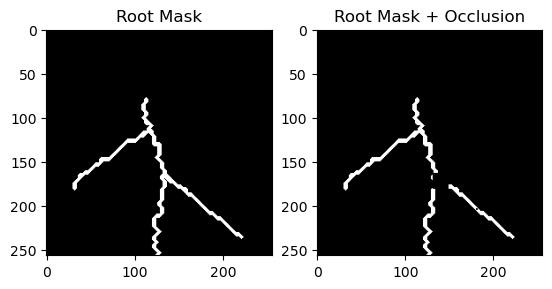

In [7]:
img, pr_root_coordinates, llr_root_coordinates, rlr_root_coordinates = root_mask_simulator(patch_size=256)
potential_occlusion_centers = get_potential_occlusion_centers(pr_root_coordinates, llr_root_coordinates, rlr_root_coordinates)
occluded_img = occluder(img, potential_occlusion_centers, max_num_occ=5, max_size_occ=20)
f, ax = plt.subplots(1, 2)
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Root Mask')
ax[1].imshow(occluded_img, cmap='gray')
ax[1].set_title('Root Mask + Occlusion')

In [8]:
def root_data_generator(batch_size, patch_size, max_num_occ, max_size_occ):
    while True:  # Loop indefinitely
        batch_images = []
        batch_labels = []

        for i in range(batch_size):
            # Generate or load an image and its label here
            # For demonstration, we'll just use random data
            label, pr_root_coordinates, llr_root_coordinates, rlr_root_coordinates = root_mask_simulator(patch_size)
            potential_occlusion_centers = get_potential_occlusion_centers(pr_root_coordinates, llr_root_coordinates, rlr_root_coordinates)
            image = occluder(label, potential_occlusion_centers, max_num_occ, max_size_occ)

            batch_images.append(image)
            batch_labels.append(label)

        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        yield batch_images, batch_labels

In [9]:
batch_size = 32
patch_size = 256
max_num_occ = 5
max_size_occ = 20
train_generator = root_data_generator(batch_size, patch_size, max_num_occ, max_size_occ)

In [10]:
X, y = next(train_generator)

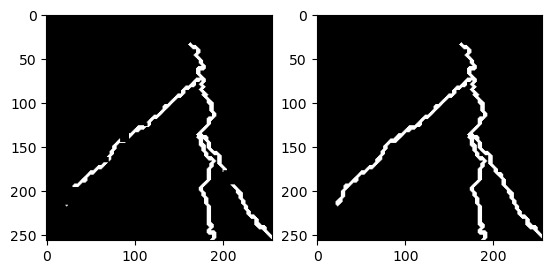

In [11]:
f, ax = plt.subplots(1, 2)
example_id = np.random.randint(0, batch_size)
ax[0].imshow(X[example_id], cmap='gray')
ax[1].imshow(y[example_id], cmap='gray')

In [12]:
import tensorflow as tf
import keras.backend as K
# Let's implement two custom metrics f1 score and iou
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1])
    model.summary()
    
    return model

In [14]:
from keras.callbacks import EarlyStopping

model = simple_unet_model(patch_size, patch_size, 1)

cb = EarlyStopping(monitor='loss',
                   patience=5,
                   restore_best_weights='True',
                   mode='min')

2024-02-22 18:27:46.747116: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-22 18:27:46.747138: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-22 18:27:46.747143: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-22 18:27:46.747560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-22 18:27:46.747806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs = 20,
    callbacks=[cb]
)

Epoch 1/20


2024-02-22 18:27:51.169056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 52s 364ms/step - loss: 0.0523 - accuracy: 0.9898 - f1: 0.8592
Epoch 2/20
100/100 [==============================] - 36s 355ms/step - loss: 0.0052 - accuracy: 0.9980 - f1: 0.9649
Epoch 3/20
100/100 [==============================] - 36s 356ms/step - loss: 0.0036 - accuracy: 0.9984 - f1: 0.9710
Epoch 4/20
100/100 [==============================] - 36s 355ms/step - loss: 0.0031 - accuracy: 0.9986 - f1: 0.9748
Epoch 5/20
100/100 [==============================] - 36s 361ms/step - loss: 0.0028 - accuracy: 0.9988 - f1: 0.9785
Epoch 6/20
100/100 [==============================] - 36s 358ms/step - loss: 0.0025 - accuracy: 0.9989 - f1: 0.9813
Epoch 7/20
100/100 [==============================] - 36s 358ms/step - loss: 0.0023 - accuracy: 0.9990 - f1: 0.9826
Epoch 8/20
100/100 [==============================] - 35s 354ms/step - loss: 0.0022 - accuracy: 0.9991 - f1: 0.9836
Epoch 9/20
100/100 [==============================] - 36s 358ms/step - loss: 0.0021

In [16]:
X, y = next(train_generator)
y_pred = model.predict(X)

2024-02-22 18:39:57.396006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


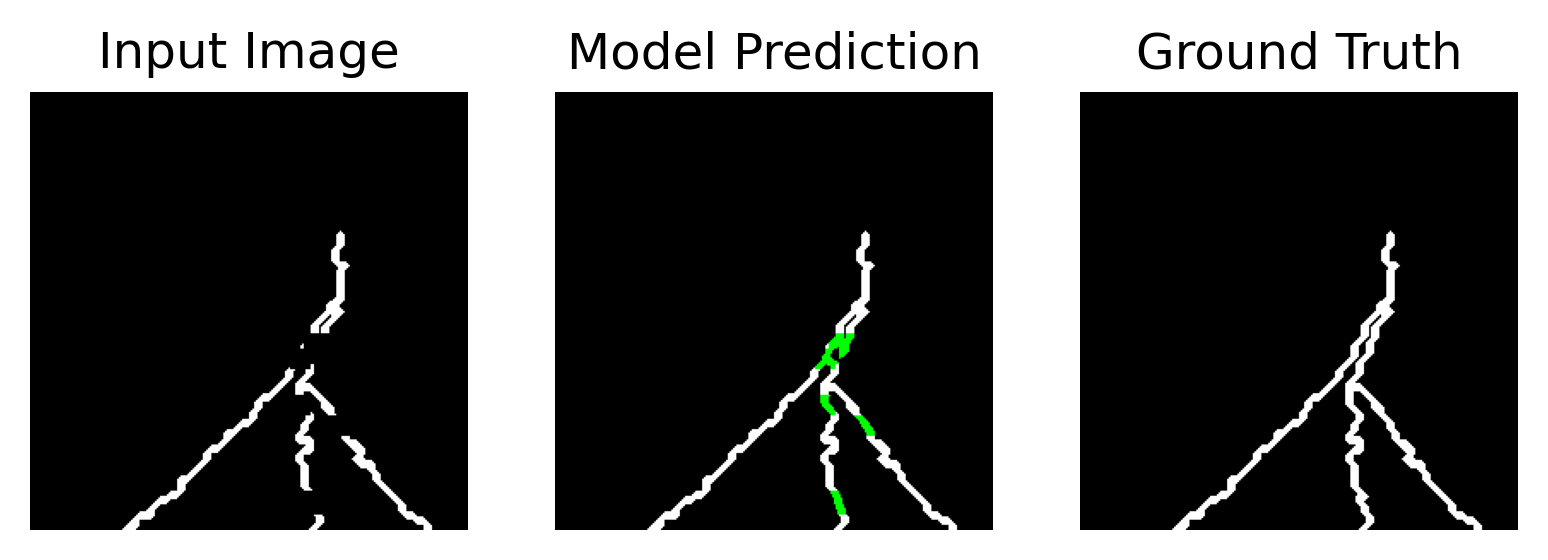

In [18]:
im_id = np.random.randint(0, batch_size)
f, ax = plt.subplots(1, 3, dpi=300)
input_image = X[im_id]
predicted_image = y_pred[im_id]>0.5
predicted_image = predicted_image.reshape(patch_size, patch_size)
ground_truth = y[im_id]

rgb_image = np.dstack((input_image, input_image, input_image)) * 255
green = rgb_image[:, :, 1]
green[(predicted_image == 1) & (input_image == 0)] = 255
rgb_image[:, :, 1] = green

ax[0].imshow(input_image, cmap='gray')
ax[0].set_title('Input Image')
ax[0].set_axis_off()
ax[1].imshow(rgb_image, cmap='gray')
ax[1].set_title('Model Prediction')
ax[1].set_axis_off()
ax[2].imshow(ground_truth, cmap='gray')
ax[2].set_title('Ground Truth')
ax[2].set_axis_off()

In [23]:
import cv2
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding / 2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding / 2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding,
                                      cv2.BORDER_CONSTANT, value=[25, 48, 121])

    return padded_image

In [48]:
from patchify import patchify, unpatchify

overlapping_image = cv2.imread("overlapping_masks/valerian/000_43-18-ROOT1-2023-08-08_pvdCherry_OD001_Col0_01-Fish Eye Corrected_predicted.tif")[:,0:4112]
dims = []
patch_size = 256
overlapping_image = padder(overlapping_image, patch_size)
patches = patchify(overlapping_image, (patch_size, patch_size, 1), step=patch_size)
dims.append([overlapping_image.shape, patches.shape])

patches = patches.reshape(-1, patch_size, patch_size, 1)


In [50]:
preds = model.predict(patches)

7/7 [==============================] - 1s 116ms/step


In [52]:
preds = preds.reshape(12, 17, 1, 256, 256, 1)  # reshape the prediction
prediction_image = unpatchify(preds, (3072, 4352, 1))

In [54]:
# fig = plt.figure(figsize=(3.54,3.54), dpi=600)
# plt.imshow(prediction_image, cmap='grey')

cv2.imwrite("overlapped_w_discontinuityapplied.png", prediction_image)

True

In [51]:
dims

[[(3072, 4352, 3), (12, 17, 1, 256, 256, 1)]]